In [3]:
from os import sys, path
sys.path.append(path.dirname(path.dirname(path.abspath('__file__'))))

In [4]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

In [5]:
from algorithms.hmm import ForwardBackwardAlgorithm

In [6]:
from hmmlearn import hmm
from sklearn import metrics
from sklearn import preprocessing

In [7]:
import trueskill as ts
from trueskill import Rating
from pack.utils import (transition_matrix_pxx,
                        emission_probabilities_pyx)
import h5py

/home/kasper/PycharmProjects/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [141]:
df = pd.read_csv('/home/kasper/Dropbox/Scrapping/soccerway/csv/final_data_soccerway.csv', index_col='Unnamed: 0')

In [9]:
pred_data = pd.read_csv('../data/predict.csv', index_col='Unnamed: 0')
df_teams = pred_data[['home_team','away_team']].values
df_teams

array([['Flora', 'Nõmme Kalju'],
       ['AaB', 'Sparta Praha'],
       ['Zürich', 'Winterthur'],
       ['Slovan Bratislava', 'Újpest'],
       ['Chelsea', 'AFC Bournemouth'],
       ['Standard Liège', 'Club Brugge'],
       ['Sporting CP', 'Vitória Guimarães'],
       ['Chaves', 'Vitória Setúbal'],
       ['Boavista', 'Marítimo'],
       ['Boavista', 'Internacional'],
       ['Exeter City', 'Forest Green Rovers'],
       ['Stirling Albion', 'Cowdenbeath'],
       ['Leganés', 'Sevilla']], dtype=object)

In [72]:
result_key = 'result_final'
n_states = 3

In [73]:
for p, pair in enumerate(df_teams):
    print(pair)
# p = 0

    h5f = h5py.File('./elo_temp/elo_pairs_'+str(p)+'.h5','r')

    champ = list(h5f.keys())[0]

    teams = list(h5f[champ].keys())

    teamh = df_teams[p,0]
    teama = df_teams[p,1]

    datah = h5f[champ][teamh][:]
    dataa = h5f[champ][teama][:]
    h5f.close()

    ht = pd.DataFrame(datah[1],columns=[teamh],index=datah[0].astype(int))
    at = pd.DataFrame(dataa[1],columns=[teama],index=dataa[0].astype(int))

    ht.iloc[1:] = ht.values[0:-1]
    ht.iloc[0] = 100
    at.iloc[1:] = at.values[0:-1]
    at.iloc[0] = 100

    htd = ht.diff().replace(np.nan, 0).astype(int)
    atd = at.diff().replace(np.nan, 0).astype(int)

    # GET STATES 

    h5f = h5py.File('../data/elo_ratings/states/elo_states_pair_'+str(p)+'.h5','w')

    ### home as home

    # h5f.create_group('HaH')

    x_df_home = df.loc[htd.index]
    x_df_home = x_df_home[x_df_home.home_team==htd.columns[0]]
    x_home = x_df_home[result_key].dropna().values
    ix_home = x_df_home.index.values
    y_home = htd.loc[ix_home].values.reshape(-1)

    data = np.array(list(zip(ix_home, x_home, y_home)))
    h5f.create_dataset('HaH', data=data)

    ### away

    x_df_away = df.loc[atd.index]
    x_df_away = x_df_away[x_df_away.away_team==atd.columns[0]]
    x_away = x_df_away[result_key].dropna().values
    ix_away = x_df_away.index.values
    y_away = atd.loc[ix_away].values.reshape(-1)

    data = np.array(list(zip(ix_away, x_away, y_away)))
    h5f.create_dataset('AaA', data=data)

    ### all

    #### Home team as home and away

    # h5f.create_dataset('ashome')

    ix_Hall = htd.index.values
    x_Hall = df.loc[htd.index][result_key].dropna().values
    y_Hall = htd.values.reshape(-1)

    data = np.array(list(zip(ix_Hall, x_Hall, y_Hall)))
    h5f.create_dataset('HomeALL', data=data)

    #### Away team as home and away

    # h5f.create_dataset('ashome')

    ix_Aall = atd.index.values
    x_Aall = df.loc[atd.index][result_key].dropna().values
    y_Aall = atd.values.reshape(-1)

    data = np.array(list(zip(ix_Aall, x_Aall, y_Aall)))
    h5f.create_dataset('AwayALL', data=data)

    h5f.close()

['Flora' 'Nõmme Kalju']
['AaB' 'Sparta Praha']
['Zürich' 'Winterthur']
['Slovan Bratislava' 'Újpest']
['Chelsea' 'AFC Bournemouth']
['Standard Liège' 'Club Brugge']
['Sporting CP' 'Vitória Guimarães']
['Chaves' 'Vitória Setúbal']
['Boavista' 'Marítimo']
['Boavista' 'Internacional']
['Exeter City' 'Forest Green Rovers']
['Stirling Albion' 'Cowdenbeath']
['Leganés' 'Sevilla']


In [74]:
scenarios = ['HaH','AaA','HomeALL','AwayALL']

In [75]:
outcomes = []

for p, pair in enumerate(df_teams):
    print(pair)
    # p=0
    suboutcomes = []
    h5f = h5py.File('../data/elo_ratings/states/elo_states_pair_'+str(p)+'.h5','r')
    for scenario in scenarios:
        print(scenario)
        data  = h5f[scenario][:]
        HaH = pd.DataFrame(data[:,[1,2]], index=data[:,0].astype(int))

    #     HaH.head()

        x_df = pd.DataFrame(HaH[0].values,columns=[result_key], index=HaH.index)
        y_df = pd.DataFrame(HaH[1].values,columns=[result_key], index=HaH.index)
        ys = y_df.values.reshape(-1)


        train = -5

        unique_observed_data_elo_ratings = np.unique(ys)
        le = preprocessing.LabelEncoder()
        le.fit(unique_observed_data_elo_ratings)
        transformed_observed_data_elo_ratings = le.transform(ys)

        pxx = transition_matrix_pxx(data=x_df.iloc[:train],result=result_key, n_states=n_states)
        pyx = emission_probabilities_pyx(x_df=x_df.iloc[:train], y_df=y_df.iloc[:train], x_label=result_key, hidden_states=n_states)
        px = x_df.iloc[:train][result_key].value_counts(normalize=True).sort_index()

        george_says = transformed_observed_data_elo_ratings.reshape(-1, 1)[train-5:]

        try:
            fba = ForwardBackwardAlgorithm(px, pxx, pyx, george_says)
            forward = fba.forward()

            backward = fba.backward()
            gammas = fba.gammas()
            ytrue = x_df.values.reshape(-1)[train-5:]
            ypred = np.argmax(gammas, axis=1)
            ac = metrics.accuracy_score(y_pred=ypred,y_true=ytrue)
            suboutcomes.append(ac)
        except Exception as e:
            print(e)
    outcomes.append(suboutcomes)
    h5f.close()

['Flora' 'Nõmme Kalju']
HaH
AaA
HomeALL
AwayALL
['AaB' 'Sparta Praha']
HaH
AaA
HomeALL
AwayALL
['Zürich' 'Winterthur']
HaH
AaA
HomeALL
AwayALL
['Slovan Bratislava' 'Újpest']
HaH
AaA
HomeALL
AwayALL
['Chelsea' 'AFC Bournemouth']
HaH
AaA
HomeALL
AwayALL
['Standard Liège' 'Club Brugge']
HaH
AaA
HomeALL
AwayALL
['Sporting CP' 'Vitória Guimarães']
HaH
AaA
HomeALL
AwayALL
['Chaves' 'Vitória Setúbal']
HaH
AaA
HomeALL
AwayALL
['Boavista' 'Marítimo']
HaH
AaA
HomeALL
AwayALL
['Boavista' 'Internacional']
HaH
AaA
HomeALL
AwayALL
['Exeter City' 'Forest Green Rovers']
HaH
AaA
HomeALL
AwayALL
['Stirling Albion' 'Cowdenbeath']
HaH
AaA
HomeALL
AwayALL
['Leganés' 'Sevilla']
HaH
AaA
HomeALL
AwayALL


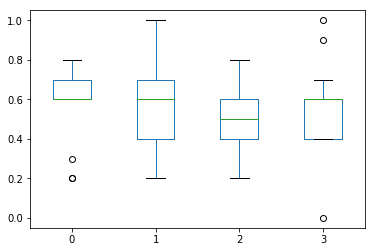

In [76]:
pd.DataFrame(outcomes).plot(kind='box')

# generate dataset for classifier

In [77]:
# for p, pair in enumerate(df_teams):
#     print(pair)
p = 0

h5f = h5py.File('./elo_temp/elo_pairs_'+str(p)+'.h5','r')

In [79]:
champ = list(h5f.keys())[0]

teams = list(h5f[champ].keys())

In [144]:
ixs = np.array([])
for team in teams[:]:    
    ix = h5f[champ][team][:].T[:,0]
#     df = pd.DataFrame(np.array([ar_data[1]]),columns=[team],index=[ar_data[0].astype(int)])
    ixs = np.append(ixs, ix)
uni = np.unique(ixs).astype(int)

In [145]:
uni

array([   8978,    9102,    9246, ..., 2112163, 2112164, 2112165])

In [151]:
da = df.loc[uni][['home_team','away_team','result_final']]

In [159]:
row[1]

home_team       Skënderbeu Korçë
away_team                 Vaslui
result_final                   2
Name: 993788, dtype: object

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [182]:
import progressbar

In [184]:
da.shape

(43434, 3)

In [188]:

match_pairs = []
elos =np.zeros((da.shape[0],2))
for i, (ix, row) in enumerate(da.iloc[:2000].iterrows()):
    if i%1000==0:
        print(i,da.shape[0])
    try:
        hdhome = h5f[champ][row.home_team][:].T
        hdaway = h5f[champ][row.away_team][:].T
        elohome = hdhome[np.where(hdhome==ix)[1],1]
        eloaway = hdaway[np.where(hdaway==ix)[1],1]
        elos[i,0] = elohome
        elos[i,1] = eloaway
    except Exception as e:
        print(e)

0 43434
1000 43434


In [191]:
elos_df = pd.DataFrame(elos, columns=['EH','EA'], index=da.index)

In [196]:
final = pd.concat([da,elos_df],axis=1)

In [180]:
elohome

array([109.85612816, 109.85612816])

In [117]:
ar_data[0].astype(int)

163830

In [111]:
dfs[1]

,Mafra
224,471.0
0,1.0
0,-9.0


In [98]:
ar_data = h5f[champ][team][:].T[r]

In [99]:
ar_data

array([1.543479e+06, 1.000000e+02])

In [94]:
tot = pd.concat(dfs, axis=0, ignore_index=False)

KeyboardInterrupt: 

In [85]:
tot

,Beroe,Brattvåg,Derby County B,Fairford Town,Mafra,Paksi SE,Progresul Cernica,Sparta Rotterdam II,Südburgenland,Wincanton Town
224,NaN,471.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,NaN,NaN,NaN,NaN,471.0,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,-9.0,NaN,NaN,NaN,NaN,NaN
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,471.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.0
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,471.0,NaN,NaN


In [ ]:
h5f.close()

In [55]:
len(outcomes)

13

In [ ]:
ypred

In [ ]:
metrics.recall_score(y_pred=ypred, y_true=ytrue, pos_label=0)

In [ ]:
ypred

In [ ]:
ytrue

In [ ]:
transformed_observed_data_elo_ratings.shape

In [ ]:
bob_says = transformed_observed_data_elo_ratings.reshape(-1,1)[-470:]
model = model.fit(bob_says)

In [ ]:
transformed_observed_data_elo_ratings.reshape(-1, 1)[-10:]

In [ ]:
bob_says

In [ ]:
h5f.close()

In [1]:
ts

NameError: name 'ts' is not defined

In [ ]:
print("Bob said:", ", ".join(map(lambda x: observations[int(x)], bob_says)))
print("Alice Believes:", ", ".join(map(lambda x: states[x], alice_hears)))

In [ ]:
h5f.close()

In [ ]:
pxx = transition_matrix_pxx(data=df.loc[htd.index]['result_final'].dropna().to_frame(),result='result_final',n_states=3)

pyx = emission_probabilities_pyx(x_df=df.loc[htd.index]['result_final'].dropna().to_frame(),x_label='result_final',hidden_states=3,y_df=htd)

px = df.loc[htd.index]['result_final'].value_counts(normalize=True).sort_index()

px

pxx

In [ ]:
df.loc[htd.index]['result_final'].dropna().to_frame()

In [ ]:
a = df[((df.home_team==teamh) & (df.away_team==teama)) | ((df.home_team==teama)&(df.away_team==teamh))]

In [ ]:
a

In [ ]:
l = pd.concat([ht,at],axis=1)

In [ ]:
l.plot()
# l.loc[a.index].plot()

In [ ]:
pd.concat([htd,atd],axis=1).plot()

In [ ]:
pd.concat([ht,at],axis=1).plot()

In [ ]:
ht.plot()
at.plot()

In [ ]:
# df.loc[995088]

In [ ]:
# df[((df.home_team==teams[i]) | (df.away_team==teams[i])) & (df.championship==champ)]

In [ ]:
# df.loc[2054071]

In [ ]:
import itertools
import math
import trueskill
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)

In [ ]:
BETA = ts.BETA

In [ ]:
def win_probability(a, b):                                                      
    deltaMu = sum([x.mu for x in a]) - sum([x.mu for x in b])                   
    sumSigma = sum([x.sigma ** 2 for x in a]) + sum([x.sigma ** 2 for x in b])  
    playerCount = len(a) + len(b)                                               
    denominator = math.sqrt(playerCount * (BETA * BETA) + sumSigma)             
    return cdf(deltaMu / denominator)  

In [ ]:
teams = np.arange(100)
ratings = [Rating() for i in range(100)]
for i in range(100):
    choice = np.random.choice(teams,size=2,replace=True)
    a = ratings[choice[0]]
    b = ratings[choice[1]]
    q = quality_1vs1(a, b)
    wp = win_probability([a],[b])
    print(wp)
    a, b = ts.rate_1vs1(a, b, drawn=False)
    
    ratings[choice[0]] = a
    ratings[choice[1]] = b

In [ ]:
mus = [r.mu for r in ratings]
sigma = [r.sigma for r in ratings]